In [1]:
pip install pandas


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Explore Data and set it up for the training and test

In [3]:
# Set up feedback system
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data, separate features from target
data = pd.read_csv("synthetic_credit_card_approval.csv")
X = data.drop(["Target"], axis=1)
y = data["Target"]

# Break into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Preview the data
print("Data successfully loaded!\n")
X_train.head()

Data successfully loaded!



,Num_Children,Group,Income,Own_Car,Own_Housing
288363,1,1,40690,0,1
64982,2,0,75469,1,0
227641,1,1,70497,1,1
137672,1,1,61000,0,0
12758,1,1,56666,1,1


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Total approvals: 38246
Group A: 8028 (20.99% of approvals)
Group B: 30218 (79.01% of approvals)

Overall accuracy: 94.79%
Group A: 94.56%
Group B: 95.02%

Sensitivity / True positive rate:
Group A: 77.23%
Group B: 98.03%


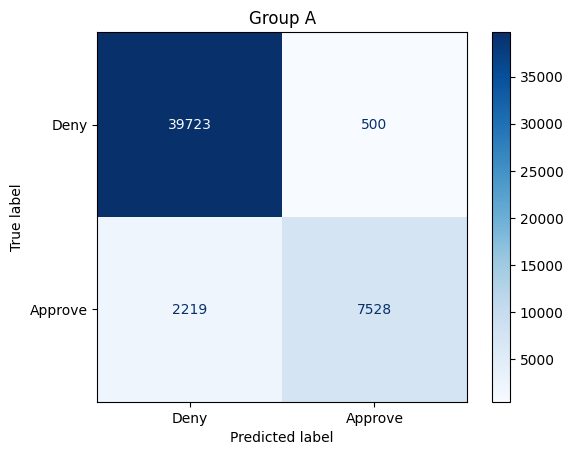

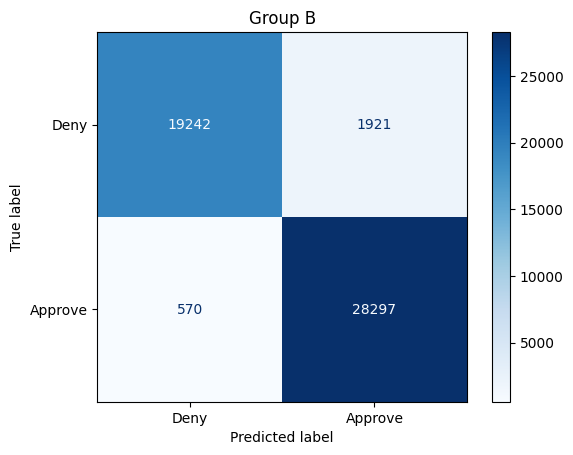

In [5]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train a model and make predictions
model_baseline = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
model_baseline.fit(X_train, y_train)
preds_baseline = model_baseline.predict(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Deny", "Approve"],
                          include_values=True, xticks_rotation='horizontal', values_format='',
                          normalize=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    return cm, disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation,
                     values_format=values_format)

# Function to evaluate the fairness of the model
def get_stats(X, y, model, group_one, preds):
        
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    print("Total approvals:", preds.sum())
    print("Group A:", preds_zero.sum(), "({}% of approvals)".format(round(preds_zero.sum()/sum(preds)*100, 2)))
    print("Group B:", preds_one.sum(), "({}% of approvals)".format(round(preds_one.sum()/sum(preds)*100, 2)))
    
    print("\nOverall accuracy: {}%".format(round((preds==y).sum()/len(y)*100, 2)))
    print("Group A: {}%".format(round((preds_zero==y_zero).sum()/len(y_zero)*100, 2)))
    print("Group B: {}%".format(round((preds_one==y_one).sum()/len(y_one)*100, 2)))
    
    cm_zero, disp_zero = plot_confusion_matrix(model, X_zero, y_zero, preds_zero)
    disp_zero.ax_.set_title("Group A")
    cm_one, disp_one = plot_confusion_matrix(model, X_one, y_one, preds_one)
    disp_one.ax_.set_title("Group B")
    
    print("\nSensitivity / True positive rate:")
    print("Group A: {}%".format(round(cm_zero[1,1] / cm_zero[1].sum()*100, 2)))
    print("Group B: {}%".format(round(cm_one[1,1] / cm_one[1].sum()*100, 2)))
    
# Evaluate the model    
get_stats(X_test, y_test, model_baseline, X_test["Group"]==1, preds_baseline)

In [6]:
pip install fairlearn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: fairlearn in c:\users\erimu\appdata\local\programs\python\python37\lib\site-packages (0.7.0)




[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Setting up the data for Training and Testing using the Gridsearch Reduction from Fairlearn

In [7]:
#pip install --save fairlearn-widget
import pandas as pd
from sklearn import metrics as skm
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from fairlearn.reductions import DemographicParity, ErrorRate, GridSearch
from fairlearn.metrics import (
    MetricFrame, selection_rate, count, selection_rate_difference
)
import pandas as pd
data = pd.read_csv("synthetic_credit_card_approval.csv")
X = data.drop(["Target"], axis=1)
Y = data["Target"]
A = X["Group"]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(
    X_scaled, Y, A, train_size=0.8, test_size=0.2, random_state=0, stratify=Y
)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Work around indexing bug
X_train = X_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)


In [8]:
unmitigated_predictor = LogisticRegression(solver="liblinear", fit_intercept=True)

unmitigated_predictor.fit(X_train, Y_train)

LogisticRegression(solver='liblinear')

Looking at the accuracy and the selection rate of the unmitigated data

accuracy          0.97306
selection_rate    0.38649
count              100000
dtype: object
       accuracy selection_rate  count
Group                                
0      0.971244       0.196098  49868
1      0.974866        0.57588  50132


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='Group'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='Group'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='Group'>]],
      dtype=object)

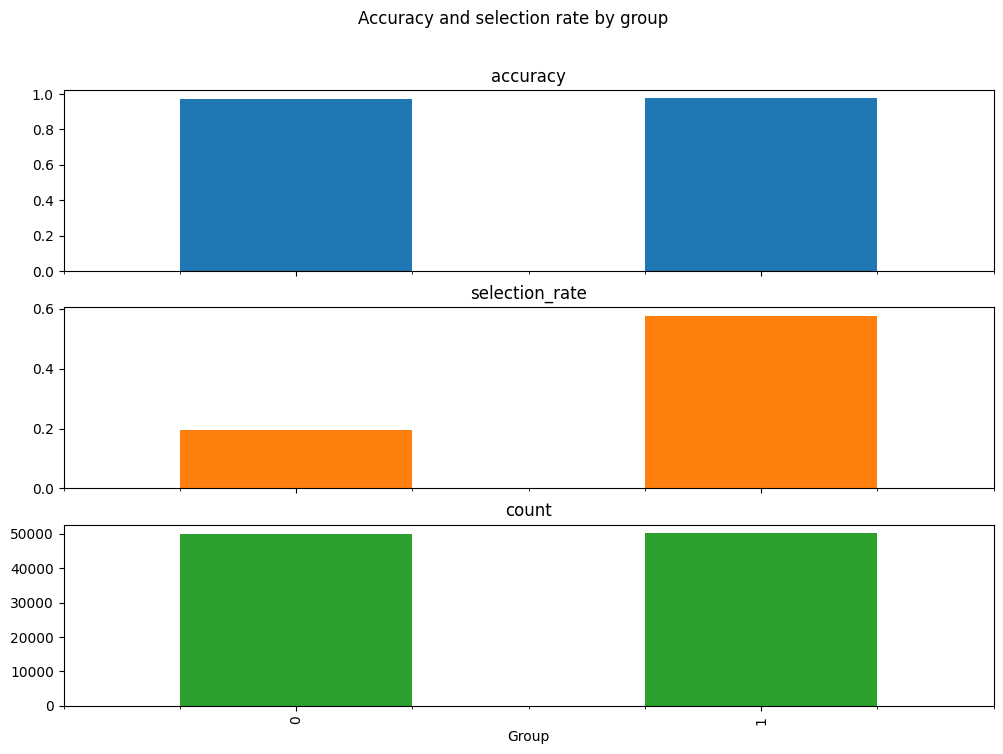

In [9]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": skm.accuracy_score,
        "selection_rate": selection_rate,
        "count": count,
    },
    sensitive_features=A_test,
    y_true=Y_test,
    y_pred=unmitigated_predictor.predict(X_test),
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 1],
    legend=False,
    figsize=[12, 8],
    title="Accuracy and selection rate by group",
)

Running the Gridsearch Reduction mitigation method

In [10]:
sweep = GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)

In [11]:
sweep.fit(X_train, Y_train, sensitive_features=A_train)
predictors = sweep.predictors_

c:\users\erimu\appdata\local\programs\python\python37\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
c:\users\erimu\appdata\local\programs\python\python37\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
c:\users\erimu\appdata\local\programs\python\python37\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keywor

In [12]:
errors, disparities = [], []
for m in predictors:

    def classifier(X):
        return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame(
    {"predictor": predictors, "error": errors, "disparity": disparities}
)

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][
        all_results["disparity"] <= row.disparity
    ]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

Text(0, 0.5, 'selection rate difference')

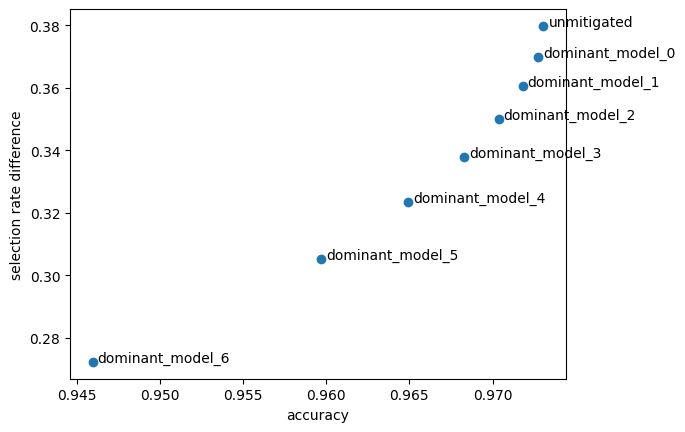

In [13]:
predictions = {"unmitigated": unmitigated_predictor.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)

    metric_frames[key] = MetricFrame(
        metrics={
            "accuracy": skm.accuracy_score,
            "selection_rate": selection_rate,
            "count": count,
        },
        sensitive_features=A_test,
        y_true=Y_test,
        y_pred=predictions[key],
    )

import matplotlib.pyplot as plt

x = [metric_frame.overall["accuracy"] for metric_frame in metric_frames.values()]
y = [
    metric_frame.difference()["selection_rate"]
    for metric_frame in metric_frames.values()
]
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")

In [14]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_consistent_length

In [15]:
keys

['unmitigated',
 'dominant_model_0',
 'dominant_model_1',
 'dominant_model_2',
 'dominant_model_3',
 'dominant_model_4',
 'dominant_model_5',
 'dominant_model_6']

In [16]:
x

[0.97306, 0.97273, 0.97181, 0.97037, 0.96827, 0.96493, 0.95968, 0.94595]

In [17]:
y

[0.37978197972848593,
 0.3699608024788089,
 0.36051851906987054,
 0.34987633289808984,
 0.33779519269737507,
 0.3235124531523935,
 0.3052087879831687,
 0.27222174687668704]